In [1]:
import theano.tensor as T
import theano
import numpy as np
import time
import pandas as pd

from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler

Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
from theano.printing import pp

In [3]:
class HiddenLayer(object):
    def __init__(self, rng, input, n_in, n_out, W = None, b = None, activation = T.tanh):
        """
        HIdden layer of MAP
        
        rng: for random state --> np.random.RandomState
        """
        self.input = input
        if W is None:
            W_values = np.asarray(
                rng.uniform(
                    low = - np.sqrt(6. / (n_in + n_out)),
                    high = np.sqrt(6. / (n_in + n_out)),
                    size = (n_in, n_out)
                    ),
                dtype = theano.config.floatX
                )
            if activation == theano.tensor.nnet.sigmoid:
                W_values *= 4.
            
            W1 = theano.shared(W_values, name='W1', borrow = True)
        
        if b is None:
            b_values = np.zeros((n_out,), dtype=theano.config.floatX)
            b1 = theano.shared(value=b_values, name='b1', borrow=True)
            
        self.W = W1
        self.b = b1
            
        lin_output = T.dot(input,self.W) + self.b
        self.output = (
            lin_output if activation is None
            else activation(lin_output)
            )
            
        self.params = [self.W, self.b]
                    

In [4]:
class OutputLayer(object):
    def __init__(self, rng, input, n_in, n_out, W = None, b = None, activation = None):
        """
        Output layer of MAP
        
        rng: for random state --> np.random.RandomState
        """
        self.input = input
        
        if W is None:
            W_values = np.asarray(
                rng.uniform(
                    low = - np.sqrt(6. / (n_in + n_out)),
                    high = np.sqrt(6. / (n_in + n_out)),
                    size = (n_in, n_out)
                    ),
                dtype = theano.config.floatX
                )
            if activation == theano.tensor.nnet.sigmoid:
                W_values *= 4
            
            W2 = theano.shared(W_values, name='W2', borrow = True)
            
        if b is None:
            b_values = np.zeros((n_out,), dtype=theano.config.floatX)
            b2 = theano.shared(value=b_values, name='b2', borrow=True)
            
        self.W = W2
        self.b = b2
            
        lin_output = T.dot(input,self.W) + self.b
        self.output = (
            lin_output if activation is None
            else activation(lin_output)
            )
            
        self.params = [self.W, self.b]

In [5]:
class MAP(object):
    
    def __init__(self, rng, input, n_in, n_hidden, n_out):
        """ Initialization
        """
        self.hiddenLayer = HiddenLayer(
            rng = rng,
            input = input,
            n_in = n_in,
            n_out = n_hidden,
            activation = T.tanh
            )
        
        self.outputLayer = OutputLayer(
            rng = rng,
            input = self.hiddenLayer.output,
            n_in = n_hidden,
            n_out = n_out
            )
        
        self.params = self.hiddenLayer.params + self.outputLayer.params
        
    def L2_regulation(self,y):
        """ Returns the L2 regulation of object vector and predicted vetor
        """
        return T.sum((y - self.outputLayer.output) ** 2)


In [6]:
class MAPPING(object):
    """ Returns the mapping function 
    X: np.array --> n_samples x n_features
    Y: np.array --> n_samples x n_features
    lam: penalization for weights
    beta: weight for sparsity penalization
    sparsity_param: desired average activation of the hidden units
    """
    def __init__(self,learning_rate = 0.01, n_epochs = 1000, batch_size = 20, 
                 n_hidden = 200, lam = 1e-4, beta = 0.5, sparsity_param = 0.05):
        self.learning_rate = learning_rate
        self.n_epochs = n_epochs
        self.batch_size = batch_size
        self.n_hidden = n_hidden
        self.lam = lam
        self.beta = beta
        self.sparsity_param = sparsity_param
        self.W1  = None
        self.W2 = None
        self.b1 = None
        self.b2 = None
        self.x_mean = None
        self.x_std = None
        self.y_mean = None
        self.y_std = None
        self.gradients = None
        self.L2 = None
        self.sparsity = None
        self.reg = None
        
    
    def fit(self,train_X,train_Y, validate_X = None, validate_Y = None, test_X = None, test_Y = None, debug = False):
        """
        debug: If true, in debug mode
        """
        
        #self.x_mean = train_X.mean()
        #self.x_std = train_X.std()
        #self.y_mean = train_Y.mean()
        #self.y_std = train_Y.std()
        #train_X = (train_X - self.x_mean) / self.x_std
        #train_Y = (train_Y - self.y_mean) / self.y_std
        shared_train_X = theano.shared(np.asarray(train_X, dtype = theano.config.floatX))
        shared_train_Y = theano.shared(np.asarray(train_Y, dtype = theano.config.floatX))
        n_train_batches = train_X.shape[0] / self.batch_size
        
        if valid_X != None and valid_Y != None:
            n_valid_batches = validate_X.shape[0] / self.batch_size
            #validate_X = (validate_X - self.x_mean) / self.x_std
            #validate_Y = (validate_Y - self.y_mean) / self.y_std
            shared_validate_X = theano.shared(np.asarray(validate_X, dtype = theano.config.floatX))
            shared_validate_Y = theano.shared(np.asarray(validate_Y, dtype = theano.config.floatX))
            
        
        ### Build model ###
        print "... building the model..."

        # allocate symbolic variables for the data
        index = T.lscalar() # index for a mini batch
        x = T.dmatrix('x')
        y = T.dmatrix('y')

        rng = np.random.RandomState(1234)

        # construct MAP class
        f_mapping = MAP(
            rng = rng,
            input = x,
            n_in = train_X.shape[1],
            n_hidden = self.n_hidden,
            n_out = train_Y.shape[1]
            )
        
        self.W1 = f_mapping.hiddenLayer.W.get_value()
        self.b1 = f_mapping.hiddenLayer.b.get_value()
        self.W2 = f_mapping.outputLayer.W.get_value()
        self.b2 = f_mapping.outputLayer.b.get_value()
        

        ### Cost function ########################################################
        hidden_output = f_mapping.hiddenLayer.output
        rho_hat = (T.sum(hidden_output, axis = 0) / train_X.shape[0] + 1) / 2 ## rescale to [0,1]
        L2 = f_mapping.L2_regulation(y)/ self.batch_size * 0.5 # penalization for vector
        reg = 0.5 * self.lam * (T.sum(f_mapping.hiddenLayer.W ** 2) + T.sum(f_mapping.hiddenLayer.b **2) + 
                                T.sum(f_mapping.outputLayer.W ** 2) + T.sum(f_mapping.outputLayer.b ** 2))
        sparsity = self.beta * T.sum(self.sparsity_param * T.log(self.sparsity_param / rho_hat + 1e-6) + 
                                     (1. - self.sparsity_param) * T.log((1. - self.sparsity_param + 1e-6) / ( 1. - rho_hat)))
        cost = L2  + reg + sparsity
        
        
        

        # compute the gradient of the cost wrt to parameters
        gparams = [T.grad(cost,param) for param in f_mapping.params]
        

        # specify how to update parameters
        updates = [
            (param, param - self.learning_rate * gparam)
            for param, gparam in zip(f_mapping.params, gparams)
            ]
        
        train_model = theano.function(
                inputs = [index],
                outputs = [cost,L2, reg, sparsity, rho_hat],
                updates = updates,
                givens={
                    x: shared_train_X[index * self.batch_size: (index + 1) * self.batch_size],
                    y: shared_train_Y[index * self.batch_size: (index + 1) * self.batch_size]
                    }
                )
        

        
        if validate_X != None and validate_Y != None:
            validate_model = theano.function(
                inputs = [],
                outputs = f_mapping.L2_regulation(y),
                givens = {
                    x: shared_validate_X,
                    y: shared_validate_Y,
                    }
                )

        
        
        ## function to train the parameters
        if debug:
            ## store intermediate values
            
            
            initialization = theano.function(
                inputs = [index],
                outputs = [cost,L2, reg, sparsity],
                givens={
                    x: shared_train_X[index * self.batch_size: (index + 1) * self.batch_size],
                    y: shared_train_Y[index * self.batch_size: (index + 1) * self.batch_size]
                    }
                )
            
            train_gparams = theano.function(
                inputs = [index],
                outputs = gparams,
                givens={
                    x: shared_train_X[index * self.batch_size: (index + 1) * self.batch_size],
                    y: shared_train_Y[index * self.batch_size: (index + 1) * self.batch_size]
                    }
                )
            
        
            
           

        ################### 
        #train the model
        ###################
        print "..training the model..."
        
        if validate_X != None and validate_Y != None:
            patience = 7000
            patience_increase = 2
            improvement_threshold = 0.9995
            validation_frequency = min(n_train_batches, patience / 2)
            best_validation_loss = np.inf
            done_looping = False
        else:
            min_cost = np.inf
        best_W1 = f_mapping.hiddenLayer.W.get_value()
        best_b1 = f_mapping.hiddenLayer.b.get_value()
        best_W2 = f_mapping.outputLayer.W.get_value()
        bset_b2 = f_mapping.outputLayer.b.get_value()
        
        
        start_time = time.clock()
        epoch = 0
        
        if debug:
            initial_values = np.zeros((n_train_batches,4))
            for i in xrange(n_train_batches):
                initial_values[i] = initialization(i)
            self.gradients = [train_gparams(i) for i in xrange(n_train_batches)]
            self.cost = initial_values[:,0]
            self.L2 = initial_values[:,1]
            self.reg = initial_values[:,2]
            self.sparsity =  initial_values[:,3]


        while (epoch < self.n_epochs) and (not done_looping):
            ## shuffle train_X, train_Y
            train_X, train_Y = shuffle(train_X, train_Y)
            shared_train_X = theano.shared(np.asarray(train_X, dtype = theano.config.floatX))
            shared_train_Y = theano.shared(np.asarray(train_Y, dtype = theano.config.floatX))
            
            train_X, train_Y = shuffle(train_X, train_Y)
            epoch += 1
            minibatch_avg_cost = []
            minibatch_avg_L2 = []
            minibatch_avg_reg = []
            minibatch_avg_sparisity = []
            for minibatch_index in xrange(n_train_batches):
                tmp_out = train_model(minibatch_index)
                minibatch_avg_cost.append(tmp_out[0])
                minibatch_avg_L2.append(tmp_out[1])
                minibatch_avg_reg.append(tmp_out[2])
                minibatch_avg_sparisity.append(tmp_out[3])
                if debug:
                    self.gradients = train_gparams(minibatch_index)
                    
                iter = (epoch - 1) * n_train_batches + minibatch_index

                
                if validate_X != None and validate_Y != None:
                    if (iter + 1) % validation_frequency == 0:
                        this_validation_loss = np.sqrt(validate_model() / validate_X.shape[0])


                        print(
                            'epoch %i, minibatch %i/%i, validation error %f'%
                            (
                                epoch,
                                minibatch_index + 1,
                                n_train_batches,
                                this_validation_loss
                                )
                            )
                        
                        if debug:
                            print(
                                'epoch %i,minibatch %i/%i, cost, %f, L2 %f, reg %f, sparsity %f'%
                                (epoch,
                                 minibatch_index + 1,
                                 n_train_batches,
                                 np.average(minibatch_avg_cost),
                                 np.average(minibatch_avg_L2),
                                 np.average(minibatch_avg_reg),
                                 np.average(minibatch_avg_sparisity)
                                )
                                )
                            self.cost = minibatch_avg_cost
                            self.L2 = minibatch_avg_L2
                            self.reg = minibatch_avg_reg


                    
                    
                        if this_validation_loss < best_validation_loss:
                            self.best_W1 = f_mapping.hiddenLayer.W.get_value()
                            self.best_b1 = f_mapping.hiddenLayer.b.get_value()
                            self.best_W2 = f_mapping.outputLayer.W.get_value()
                            self.best_b2 = f_mapping.outputLayer.b.get_value()
                            self.best_validation_loss = this_validation_loss
                            
                            if this_validation_loss < best_validation_loss * improvement_threshold:
                                patience = max(patience, iter * patience_increase)
                            
                            best_validation_loss = this_validation_loss

                        
                        if patience <= iter:
                            done_looping = True
                            break

            
 
                
            
        self.W1 = self.best_W1
        self.W2 = self.best_W2
        self.b1 = self.best_b1
        self.b2 = self.best_b2
                            
        
    
    def transfrom(self,X):
        """
        X: n_sample x n_features
        """
        #X = (X - self.x_mean)/self.x_std
        Y = np.dot(np.tanh(np.dot(X,self.W1) + self.b1 ), self.W2 ) + self.b2
        return Y
        #return Y * self.y_std + self.y_mean

In [13]:
store = pd.HDFStore("../data/cifa_XY.hd5")
X = store['X'].values
Y = store['Y'].values
store.close()

In [14]:
from sklearn.cross_validation import train_test_split
tmp_X,test_X, tmp_Y, test_Y = train_test_split(X,np.array(Y),test_size = 0.05)
print tmp_X.shape
print tmp_Y.shape
print test_X.shape
print test_Y.shape

(57000, 4096)
(57000, 100)
(3000, 4096)
(3000, 100)


In [15]:
from sklearn.cross_validation import train_test_split
train_X,valid_X, train_Y, valid_Y = train_test_split(tmp_X, tmp_Y,
                                                     test_size = 0.2)

In [16]:
print train_X.shape
print train_Y.shape
print valid_X.shape
print valid_Y.shape

(45600, 4096)
(45600, 100)
(11400, 4096)
(11400, 100)


In [17]:
from sklearn.preprocessing import StandardScaler
ss_X = StandardScaler()
ss_Y = StandardScaler()
ss_X.fit(train_X)
ss_Y.fit(train_Y)
train_X, valid_X = ss_X.transform(train_X), ss_X.transform(valid_X)
train_Y, valid_Y = ss_Y.transform(train_Y), ss_Y.transform(valid_Y)
print train_X.shape
print train_Y.shape
print valid_X.shape
print valid_Y.shape

(45600, 4096)
(45600, 100)
(11400, 4096)
(11400, 100)


In [43]:
mapping = MAPPING(n_hidden = 200, n_epochs = 500, batch_size = 50, learning_rate=0.005, lam=1e-4, sparsity_param=0.05,
                 beta = 5)
%time mapping.fit(train_X,train_Y, validate_X = valid_X, validate_Y = valid_Y, test_X = test_X, test_Y= test_Y, debug = True)

... building the model...
..training the model...
epoch 1, minibatch 912/912, validation error 6.436697
epoch 1,minibatch 912/912, cost, 519.584004, L2 24.929279, reg 0.024084, sparsity 494.630641
epoch 2, minibatch 912/912, validation error 6.102990
epoch 2,minibatch 912/912, cost, 513.587556, L2 18.938922, reg 0.023533, sparsity 494.625101
epoch 3, minibatch 912/912, validation error 5.936176
epoch 3,minibatch 912/912, cost, 511.664594, L2 17.019233, reg 0.024084, sparsity 494.621277
epoch 4, minibatch 912/912, validation error 5.836351
epoch 4,minibatch 912/912, cost, 510.449611, L2 15.806045, reg 0.025088, sparsity 494.618479
epoch 5, minibatch 912/912, validation error 5.779192
epoch 5,minibatch 912/912, cost, 509.571295, L2 14.928527, reg 0.026359, sparsity 494.616409
epoch 6, minibatch 912/912, validation error 5.738256
epoch 6,minibatch 912/912, cost, 508.886342, L2 14.243487, reg 0.027799, sparsity 494.615056
epoch 7, minibatch 912/912, validation error 5.724776
epoch 7,miniba

In [49]:
mapping.best_validation_loss

5.7048940267523296

In [50]:
import cPickle

W1 = theano.shared(mapping.best_W1, name='W1', borrow = True)
W2 = theano.shared(mapping.best_W2, name='W2', borrow = True)
b1 = theano.shared(mapping.best_b1, name='b1', borrow = True)
b2 = theano.shared(mapping.best_b2, name='b2', borrow = True)
X = T.dvector(name='X')
Y = (T.dot(T.tanh(T.dot((X - ss_X.mean_)*1./ss_X.std_,W1) + b1),W2) + b2) * ss_Y.std_ + ss_Y.mean_
nn = theano.function([X],outputs = Y)

In [51]:
cPickle.dump(nn, open("../query/img2txt.pkl", "w"))

In [52]:
img2txt_model = cPickle.load(open("../query/img2txt.pkl", "r"))

In [53]:
np.linalg.norm(img2txt_model(test_X[0,:]) - test_Y[0,:])

0.12500292765668447

In [6]:
with open("/home/ce-ruoxu/workspace/data-fusion/data/cifar-10-batches-py/labels_vectors","r") as f:
    %time label_vec = cPickle.load(f)

CPU times: user 1.05 ms, sys: 42 µs, total: 1.09 ms
Wall time: 1.1 ms


In [126]:
sim_cosine_train = np.zeros((train_y_pred.shape[0],label_vec.shape[0]))
for i in xrange(train_y_pred.shape[0]):
    for j in xrange(label_vec.shape[0]):
        sim_cosine_train[i,j] = np.dot(train_y_pred[i],label_vec[j])/np.sqrt((train_y_pred[i]**2).sum())/np.sqrt((label_vec[j]**2).sum())

In [127]:
sim_cosine = np.zeros((y_pred.shape[0],label_vec.shape[0]))
for i in xrange(y_pred.shape[0]):
    for j in xrange(label_vec.shape[0]):
        sim_cosine[i,j] = np.dot(y_pred[i],label_vec[j])/np.sqrt((y_pred[i]**2).sum())/np.sqrt((label_vec[j]**2).sum())

In [128]:
train_pred = np.argsort(sim_cosine)[:,-1]

In [129]:
label_vec.shape

(10, 100)

# Evaluation

In [130]:
## number of predict classes
from collections import Counter
print Counter(np.argsort(sim_cosine)[:,-1])

Counter({3: 4550, 7: 574, 2: 362, 6: 215, 4: 201, 9: 42, 8: 29, 0: 21, 1: 6})


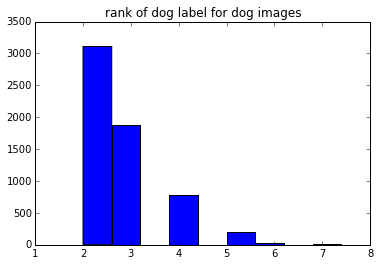

In [131]:
import matplotlib.pylab as pl
%matplotlib inline
rank = 10 - np.where(np.argsort(sim_cosine) == 5)[1]
pl.hist(rank,bins=10)
pl.title('rank of dog label for dog images')

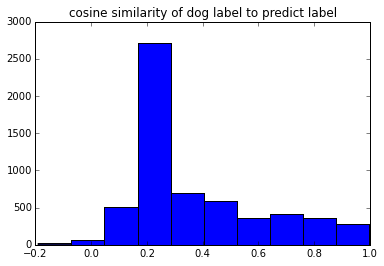

In [132]:
import matplotlib.pylab as pl
%matplotlib inline
pl.hist(sim_cosine[np.where(np.argsort(sim_cosine) == 5)])
pl.title('cosine similarity of dog label to predict label')

In [133]:
cosine_dog = np.zeros((train_x.shape[0] + test_x.shape[0],))
tmp = np.concatenate((train_y_pred, y_pred))
for i in xrange(cosine_dog.shape[0]):
    cosine_dog[i] = np.dot(label_vec[5],tmp[i])/np.sqrt((label_vec[5]**2).sum())/np.sqrt((tmp[i]**2).sum())

In [14]:
with open("/home/ce-ruoxu/workspace/data-fusion/data/cifar-10-batches-py/batches.meta","r") as f:
    meta = cPickle.load(f)

In [15]:
j = 0
info = []
for i in meta["label_names"]:
    print j, i
    info.append((j,i))
    j+= 1

0 airplane
1 automobile
2 bird
3 cat
4 deer
5 dog
6 frog
7 horse
8 ship
9 truck


In [7]:
labels = np.zeros((train_y.shape[0],))
for i in xrange(train_y.shape[0]):
    for j in xrange(label_vec.shape[0]):
        if (label_vec[j] == train_y[i]).all():
            labels[i] = j
            pass

In [138]:
for i in np.argsort(cosine_dog)[::-1][:200]:
    if i > train_x.shape[0] - 1:
        print 'dog'
    else:
        j = int(labels[i])
        print info[j][1]

dog
horse
cat
dog
dog
dog
dog
dog
cat
cat
truck
cat
cat
cat
dog
dog
dog
cat
dog
dog
dog
horse
dog
dog
dog
cat
cat
dog
cat
cat
dog
dog
cat
horse
cat
horse
dog
dog
cat
cat
dog
dog
cat
cat
cat
dog
dog
dog
deer
cat
horse
dog
dog
dog
dog
cat
dog
dog
cat
dog
dog
dog
deer
dog
dog
dog
bird
cat
deer
deer
cat
cat
dog
dog
dog
cat
horse
cat
dog
horse
dog
frog
dog
cat
cat
dog
cat
cat
cat
dog
horse
dog
dog
deer
dog
deer
deer
deer
dog
horse
cat
dog
cat
cat
cat
cat
dog
deer
dog
dog
dog
cat
cat
cat
cat
dog
dog
cat
dog
horse
cat
dog
dog
dog
deer
dog
cat
deer
bird
airplane
dog
deer
cat
deer
dog
dog
dog
horse
cat
cat
cat
dog
cat
dog
cat
cat
dog
cat
dog
dog
bird
deer
horse
dog
horse
horse
cat
cat
dog
horse
dog
dog
deer
deer
horse
cat
deer
cat
dog
dog
cat
bird
cat
cat
cat
dog
deer
cat
dog
cat
dog
dog
cat
cat
truck
deer
cat
dog
horse
dog
dog
cat
dog
dog
cat
cat
dog
cat
dog
cat


## using im2tex

In [141]:
with open("/home/ce-ruoxu/workspace/data-fusion/data/im2text/features","r") as f:
    im2text_x = cPickle.load(f)

In [143]:
with open("/home/ce-ruoxu/workspace/data-fusion/data/im2text/im2text_y","r") as f:
    im2text_y = cPickle.load(f)

In [145]:
with open("/home/ce-ruoxu/workspace/data-fusion/data/im2text/sentences.txt","r") as f:
    sentences = f.readlines()

In [ ]:
with open("data/cifar-10-batches-py/test_x","r") as f:
    %time test_x = cPickle.load(f)
with open("data/cifar-10-batches-py/test_y","r") as f:
    %time test_y = cPickle.load(f)
#train_x,train_y = test_x, test_y
with open("data/cifar-10-batches-py/train_x","r") as f:
    %time train_x = cPickle.load(f)
with open("data/cifar-10-batches-py/train_y","r") as f:
    %time train_y = cPickle.load(f)

In [ ]:
from gensim.models import Doc2Vec
model = Doc2Vec.load_word2vec_format("/home/ce-ruoxu/workspace/data-fusion/data/im2text/phrase_vectors.bin",binary = True)

In [215]:
from sklearn.cross_validation import train_test_split
train_X,valid_X, train_Y, valid_Y = train_test_split(im2text_x, im2text_y,
                                                     test_size = 0.1)

In [216]:
print train_X.shape
print train_Y.shape
print valid_X.shape
print valid_Y.shape

(8310, 4096)
(8310, 100)
(924, 4096)
(924, 100)


In [218]:
mapping = MAPPING(n_hidden = 200, n_epochs = 100, batch_size = 50, learning_rate=0.01, lam=1e-4, beta = 5)
%time mapping.fit(train_X,train_Y, valid_X, valid_Y, np.concatenate((train_x, test_x)), np.concatenate((train_y,test_y)))

... building the model...
..training the model...
epoch 1, minibatch 166/166, validation error 5235.000784
epoch 1,minibatch 166/166, train_error 57.017704
epoch 1, minibatch 166/166, test error of best model 796321.124771
epoch 2, minibatch 166/166, validation error 5162.757076
epoch 2,minibatch 166/166, train_error 51.474007
epoch 2, minibatch 166/166, test error of best model 796951.298647
epoch 3, minibatch 166/166, validation error 5141.903967
epoch 3,minibatch 166/166, train_error 49.750883
epoch 3, minibatch 166/166, test error of best model 797496.258644
epoch 4, minibatch 166/166, validation error 5142.072509
epoch 4,minibatch 166/166, train_error 48.641848
epoch 5, minibatch 166/166, validation error 5155.156144
epoch 5,minibatch 166/166, train_error 47.763960
epoch 6, minibatch 166/166, validation error 5171.989272
epoch 6,minibatch 166/166, train_error 46.988105
epoch 7, minibatch 166/166, validation error 5197.179803
epoch 7,minibatch 166/166, train_error 46.256270
epoch 8